# Building a Generative Pre-trained Transformer (GPT)

In this notebook we implement a decoder only Transformer, which can be trained for character level prediction. The network has a self-attention and fully connected layer. It doesn't implement the cross-attention. The original paper implements the model for language translation, therefore it has a decoder and encoder.



Most of the code was presented in [1], most of the theoretical background was presented in [2], [3], [4], [5]. Figures are taken from the "Attention is all you need paper" [6]. 

Notebook author: *Matjaž Zupančič*

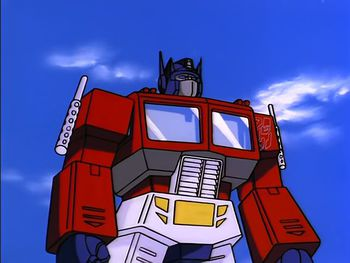

**References**:

[1] https://www.youtube.com/watch?v=kCc8FmEb1nY&t=8s&ab_channel=AndrejKarpathy

[2] https://www.youtube.com/watch?v=yGTUuEx3GkA&ab_channel=Rasa

[3] https://www.youtube.com/watch?v=tIvKXrEDMhk&ab_channel=Rasa

[4] https://www.youtube.com/watch?v=23XUv0T9L5c&ab_channel=Rasa

[5] https://www.youtube.com/watch?v=EXNBy8G43MM&ab_channel=Rasa

[6] https://arxiv.org/abs/1706.03762

## Setup

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Load the data

We'll load a tinyshakespear text. The text is loaded as a string.

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-02-09 21:28:59--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2023-02-09 21:28:59 (30.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Encoding the text

We'll encode each character with its associated position in the `chars` list (*sorted list of all unique characters that occur in the training text*). This encoding scheme is simple, but produces relatively long sequences.

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(f"encoding: ", encode("hii there"))
print(f"original: ", decode(encode("hii there")))

encoding:  [46, 47, 47, 1, 58, 46, 43, 56, 43]
original:  hii there


In [7]:
len(encode("hii there")), len("hii there")

(9, 9)

Lets encode the whole text

In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Creating batches of sequnces

In this section we'll create the training and testing sequences, which we will later feed into the transformer network. In order to split the raw text into test and train we simply take first (larger) section of the text as train and the rest of the text as test set.

We introduce a hyper-parameter called `block_size` (*it is sometimes reffered as the context length of the model*). 

In order to compute the sequences we'll compute two vectors of length `block_size`:

```
x = [18, 47, 56, 57]
y = [47, 56, 57, 58]
```

Notice that the vector `y` is `x` shifted by one character (token). From the sequences above we can form `block_size` training examples (with varying context length).

```
# a set of traning examples
input: [18], target: [47]
input: [18, 47], target: [56]
input: [18, 47, 56], target: [57]
input: [18, 47, 56, 57], target: [58]
```

The fact that the training examples have varying context length, allows us to train the transformed with contex of different size (*from a single character (token) of context up to `block_size` of context*). It also helps us in the inference stage, where we input a single character and let the transformer roll (predict the next character).

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 8 # also known as context_len
train_data[:block_size+1] # this sequence gives us 9 examples

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
x = train_data[:block_size]   
y = train_data[1:block_size+1]

print(len(x), len(y))

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

8 8
when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In order to speed up the training, we build **batches** of multiple chunks of text, that are stacked up in a single tensor.


In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the **maximum** (could be anything from 1 char to block_size) context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data

    # generate **batch_size** number of random idx into the data
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Iterate over the random idx and generate seq. (x) and targets (y)
    # us the same ofset scheme as above.
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [13]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

In [14]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


## Building the transformer Architecture

In this section we'll build the individual components in transformer architecture displayed on the figure bellow.

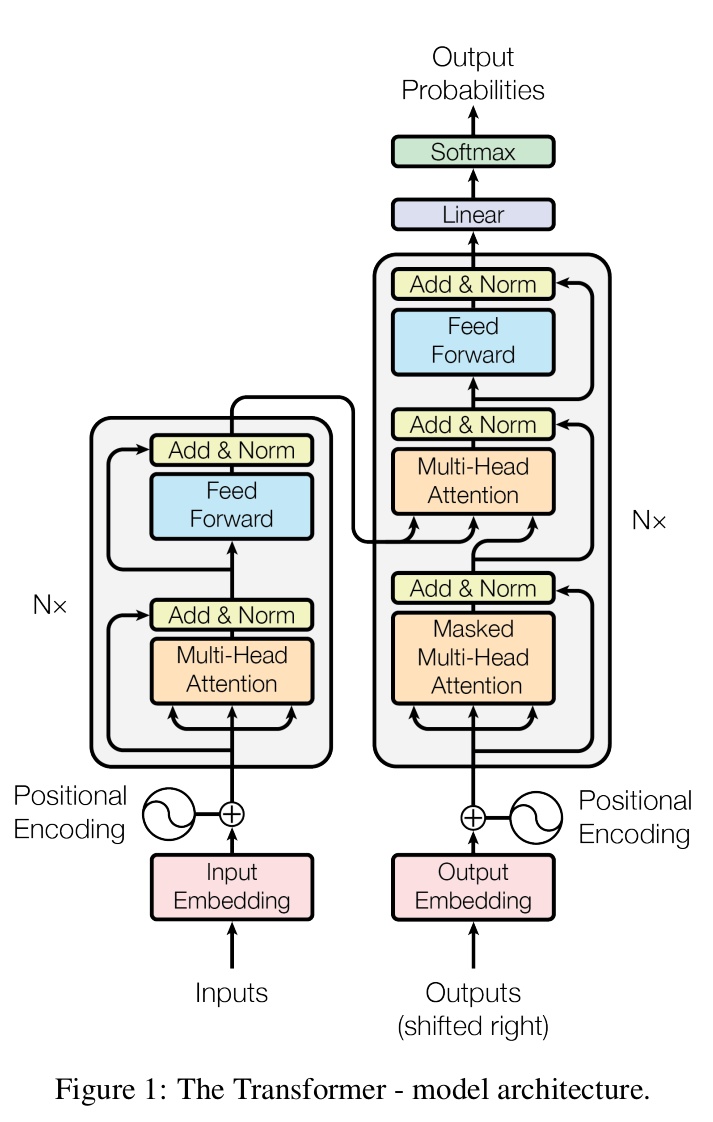

### Input Embedding

Lets start with the embedding layer. The idea behind the embedding layer is to map encoded representation of characters into a continous vector space. 

The embedding layers takes as input integers, where each integers represent a specif word or token in the vocabulary and returns a continous vector for each integer. 

The embedding layer is typically intialized with random weights and the values of the weights are updated during training to minimize the loss of the model. This allows the model to learn meaningful representations of the input tokens.

The embedding layer has two hyper parameters:

+ `num_embeddings` (*this is the number of all possible tokens, in other words it is equal to the vocabilary size*)

+ `embedding_dim` (*the dimension of generated word embeddings, i.e the dimension of the embedding space.*)

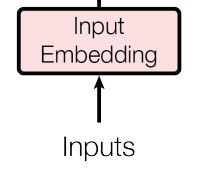

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

EMBEDDING_DIM = 16

# Lets create an embedding table
embedding_table = nn.Embedding(
    num_embeddings=vocab_size,             # number of possible tokens (words), this is the vocabulary size
    embedding_dim=EMBEDDING_DIM            # the dimension of word embedding vectors
)

In [16]:
import matplotlib.pyplot as plt

# lets embedd an example from the batch
print(f"example sequence: {xb[0]}")
print(xb[0].shape) # [block_size]

token_embeddings = embedding_table(xb[0])
token_embeddings.shape # [block_size, embedding_dim]

example sequence: tensor([24, 43, 58,  5, 57,  1, 46, 43])
torch.Size([8])


torch.Size([8, 16])

Note that once the network (and its associated embedding layer) is the trained, the tokens which share meaning will have similar vectors embeddings, for the sake of the arguements we can see that the 1 token and the 7th token on plot bellow have a similar embedding vector (i.e "they have a similar meaning")

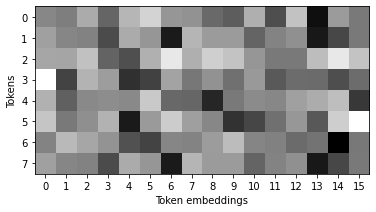

In [17]:
plt.imshow(
    token_embeddings.detach().numpy(),
    cmap="gray"
)

plt.ylabel("Tokens")
plt.xlabel("Token embeddings")
plt.yticks(list(range(block_size)));
plt.xticks(list(range(16)))
plt.plot();

In [18]:
# we can also pass the whole batch to the embedding_table
token_embeddings = embedding_table(xb)
token_embeddings.shape # [batch_size, block_size, embedding_dim]

torch.Size([4, 8, 16])

### Positional Encoding

The idea behind the positional encoding is to provide information about the relative position of token in a sequence. The order of tokens is important for determining the meaning of a sentence, so it is desired to incorporate this information into the model.

As mentioned in the paper [6], the positional encoding can either be learned or implemented in advance, in the paper they used the sin, cosine positonal encoding and showed that it produces similar results to the positional encoding that is learned.

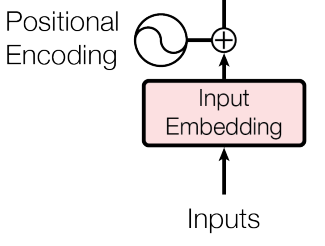

In [19]:
# Copy over the embedding table
embedding_table = nn.Embedding(
    num_embeddings=vocab_size,             
    embedding_dim=EMBEDDING_DIM
)

# Lets implement the positional embedding
positional_embedding_table = nn.Embedding(
    num_embeddings=block_size,
    embedding_dim=EMBEDDING_DIM
)

In [20]:
# Fetch the dimensions of the input tensor
batch_size, block_size = xb.shape
print(batch_size, block_size)

# Compute token embeddings for the whole batch
token_embedding = embedding_table(xb)
print(token_embedding.shape) # [batch_size, block_size, embedding_dim]

4 8
torch.Size([4, 8, 16])


In [21]:
# Compute all posible positions
# this all integers upto the block size
positions = torch.arange(block_size)
positions

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [22]:
positions_embedding = positional_embedding_table(positions)
positions_embedding.shape # [block_size, embedding_dim]

torch.Size([8, 16])

Take a look at the following plot, notice that on the y-axis we have all posible positions in which a single token can be (*any positon between 0 and `block_size - 1`*). On the x-axis we have the positional embeddings (The indivudal embeddings will be learned over time). **Also notice that the dimenson of positional embeddings is equal to the dimension of token embeddings this is because in the orginal paper the two embeddings are summed togher.**

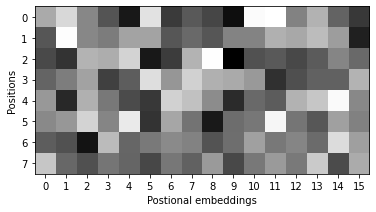

In [23]:
plt.imshow(
    positions_embedding.detach().numpy(),
    cmap="gray"
)

plt.ylabel("Positions")
plt.xlabel("Postional embeddings")
plt.yticks(list(range(block_size)));
plt.xticks(list(range(16)))
plt.plot();

In [24]:
# as in the orignal paper, we'll sum the token embeddings and the
# positional embeddings

embeddings = positions_embedding + token_embeddings
embeddings.shape

torch.Size([4, 8, 16])

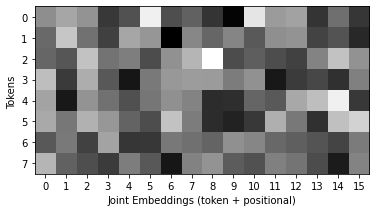

In [25]:
plt.imshow(
    embeddings[0].detach().numpy(),
    cmap="gray"
)

plt.ylabel("Tokens ")
plt.xlabel("Joint Embeddings (token + positional)")
plt.yticks(list(range(block_size)));
plt.xticks(list(range(16)))
plt.plot();

### Theory behind Self Attention and Multi Head Self Attention

In this section we'll explore the theory behind the self-attention. The theory was presented in [2], [3], [4], [5], I suggest that the reader also takes a look at the referrenced material.



#### Attention mechanism

To start we should think about what kind of attention mechanism would make sense in a language setting, for example assume the following sentence: 

"*Noa can be annoying but she is a great cat*", also assume that the model is currently focusing on the word "*she*", we wan't to think of a weighting scheme which weights all words in the original sentence such that we capture as much context as possible about the word "*she*".

We can see that the first weighing scheme `w0`, gives attention to words that are close to the word "*she*" (it turns out that proximity weighing is not a greate scheme for language). The second weighing scheme `w1` gives attention to words that share some meaning (this is much better).


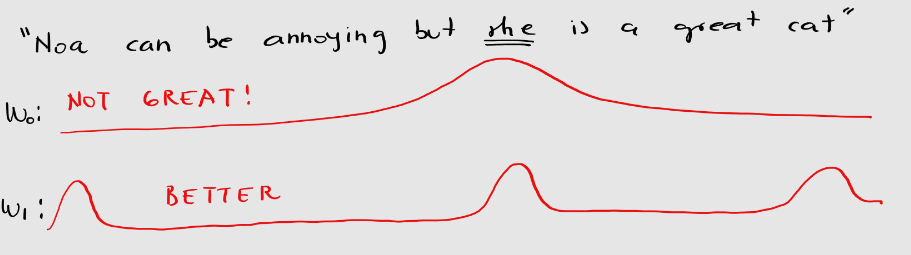

#### How can we generate the weights ?

Before answering the question, lets consider the following scheme. 

- Each word in the intput is first represented as a token `t`
- Each token is than converted to a token embedding `v`
- Token embeddings are fed into the reweighing scheme, the output is a set of embeddings with more context `y` (*notice that the size of the output is the same as the size of the input*)

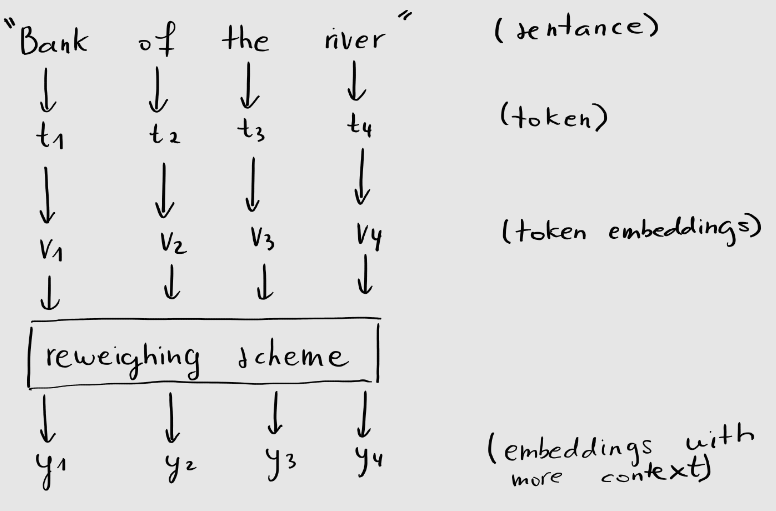

Recall that word embeddings are vectors in a `num_embeddings` dimensional space, and have the following propery: tokens and their associated embeddings that have a similar meaning are clustered together in the embedding space (*as shown on the figure bellow*). Utilizing this knowledge, we can propose the following idea for a re-weighing scheme:

$W_{12} = V_1 \cdot V_2$, 

$V_1$ and $V_2$ are the token embeddings for the first token and the second token, the resulting weight $W_{12}$ is a real number achived by computing the dot product between $V_1$ and $V_2$.

If token 1 and 2 and their associated token embeddings $V_1$ and $V_2$ share meaning, the corresponding weight $W_{12}$ will be high (since the angle $\theta$ between $V_1$ and $V_2$ is small in the embedding space).





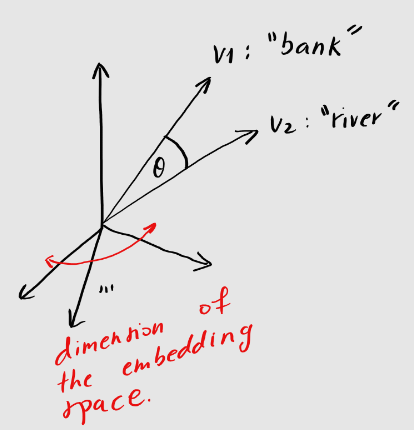


In order to compute the embedding with additional context $y_1$, we compute the dot product between $V_1$ and all other token embeddings $V_j$

$W_{11} = V_1 \cdot V_2$

$W_{12} = V_1 \cdot V_2$

$W_{13} = V_1 \cdot V_3$

$W_{14} = V_1 \cdot V_4$

In the next step we normalize weights $W_{ij}$ such that they sum up to 1.

$\sum_{j}{W_{1j}} = 1$ 

Finally we weight the individual token embeddings using their associated weight:

$y_1 = W_{11} * y_1 + W_{12} * y_2 + W_{13} * y_3 + W_{14} * y_4$

We repeat this for all other tokens:

$y_1 = W_{11} * y_1 + W_{12} * y_2 + W_{13} * y_3 + W_{14} * y_4$

$y_2 = W_{21} * y_1 + W_{22} * y_2 + W_{23} * y_3 + W_{24} * y_4$

$y_3 = W_{31} * y_1 + W_{32} * y_2 + W_{33} * y_3 + W_{34} * y_4$

$y_4 = W_{41} * y_1 + W_{42} * y_2 + W_{43} * y_3 + W_{44} * y_4$

This is called **self attention**!

One thing to keep in mind is that this scheme doesn't use any learning, the weights $W_{ij}$ are computed by simply taking the dot products of the token embeddings, later we'll add learnable parameters such that a neural network can learn what exactly it should look for when performing self attention.

#### Self-Attention Block

In this section we'll build the self-attention block and introduce parameters *Key, Query and Values*. Finally we will redraw the self-attention scheme to match the one in the paper [6].

The scheme bellow represents the operation which we formally wrtiten above. At the bottom we have token embeddings for all words in the sentance (denoted with *Keys*), at the bottom right we have a single token embedding for which we want to obtain more context (denoted with *Query*), finally at the top we again have all token embeddings in the original sentance (denoted with *Values*). At top right we have the output vector, which has more context (note that the dimension of the vector doesn't change).


Intuition behind terms *Keys*, *Queries* and *Values*:

- *Queries* are token embeddings for which we wan't to get more context
- *Keys* represent the possible context that we have in the sentance
- *Values* are the actual token embeddings (which are at the last step weighted and added up to compute the vector with more context)



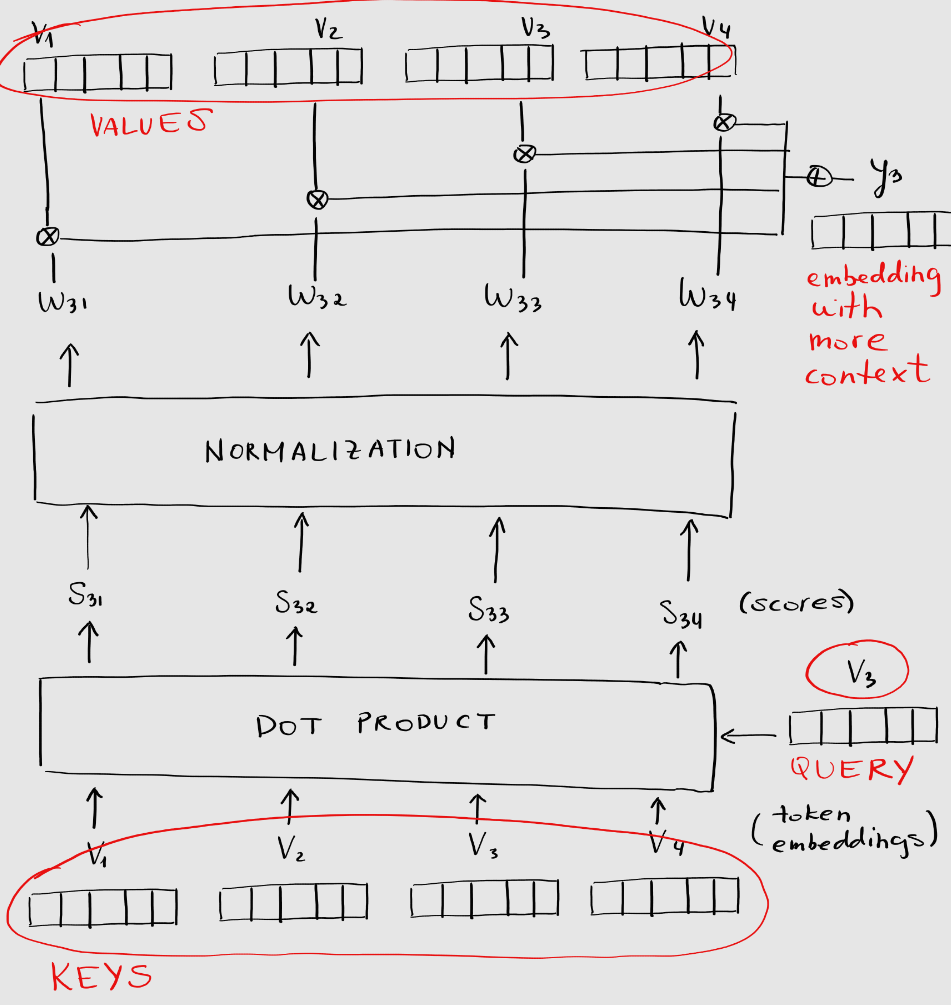

We should notice that the block above has no learnable parameters, so we should add them. Learnable parameters will be the matrices of the following shape `(embedding_dim, embedding_dim)` and will be applied to the token embeddings as follows:

$V_i^{*} = V_i @ M$, where $M$ is a matrix of shape $(k \times k)$, $V_i$ is a vector of shape $(1 \times k)$. 

We'll add three types of matrices:

- $M_k$ (weights applied on top of the *Keys*)
- $M_q$ (weights applied on top of the *Queries*) 
- $M_v$ (weights applied on top of the *Values*) 

The added matrices are shown on the figure bellow:



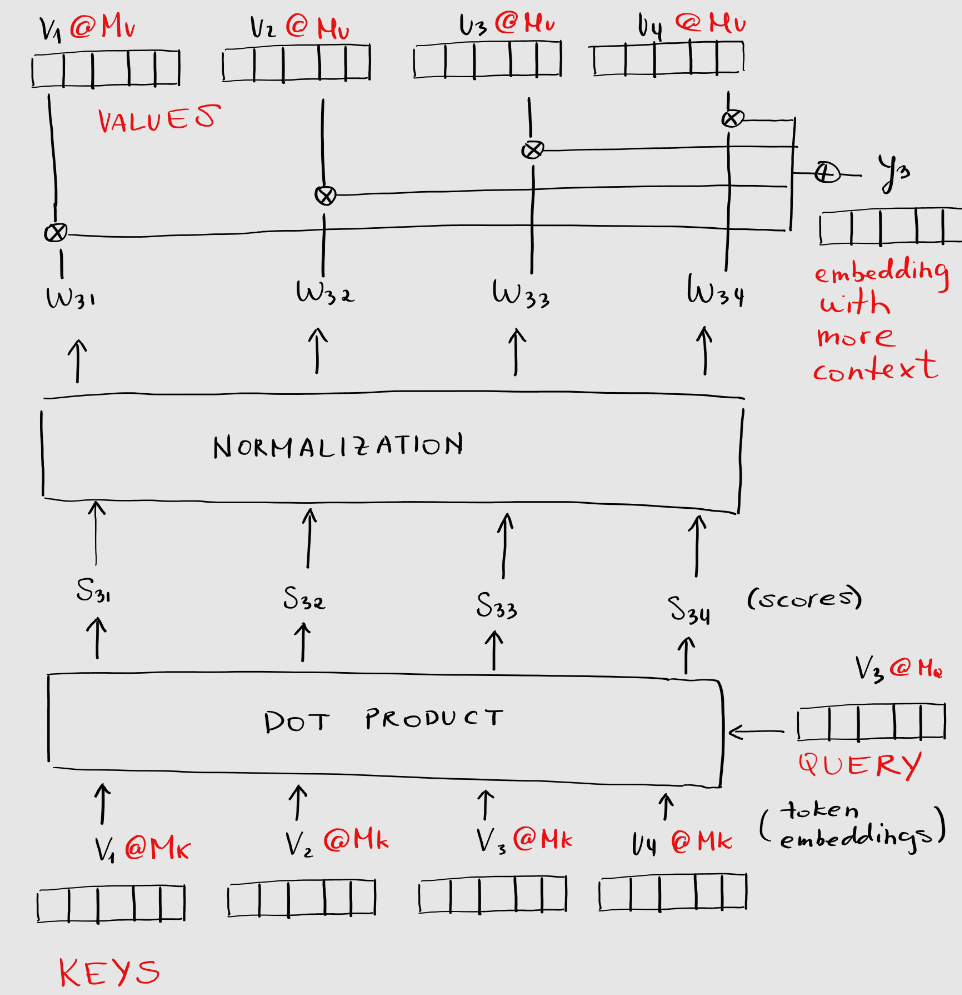

Finally lets redraw the self-attention block to match the one in the paper [6]. As mentioned the weights $M_k, M_q, M_v$ are learnable, meaning that we can learn to extract context that is relavant to the task at hand.

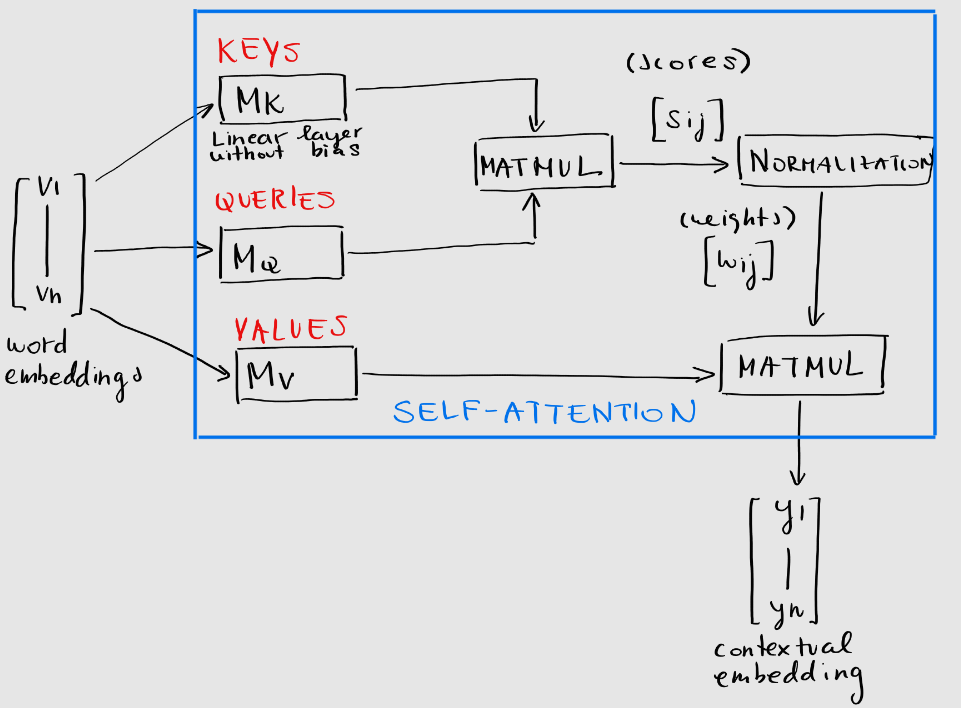

#### Multi Head Self Attention

It turns out that the architecture above has a down side. For example we should consider the following sentence: "*I gave my dog Charlie some food*", lets assume that the model is trying to attend to words for the query "*gave*", it would be reasonable to attend to the following words: 

- "*I*" (who gave ?)
- "*Charlie*" (to whom ?)
- "*food*" (what ?)

We can see that attention has to be split up among many words, to achive this we need multiple attention mechanism. This can be achived by the so called multi head self attention. The idea of multi head attention is that we stack $h$ (*head size*) linear layers ($M_k, M_q, M_v$). Now passing a vector of token embeddings results in a vector of score matrices and vector of weight matrices, therefore the output of the multi head attention is a set of $h$ contextual embeddings. The contextual embeddings are concatenated and feed into a dense layer. 

Now each self attention block in the multihead attention is giving attention to a different word.


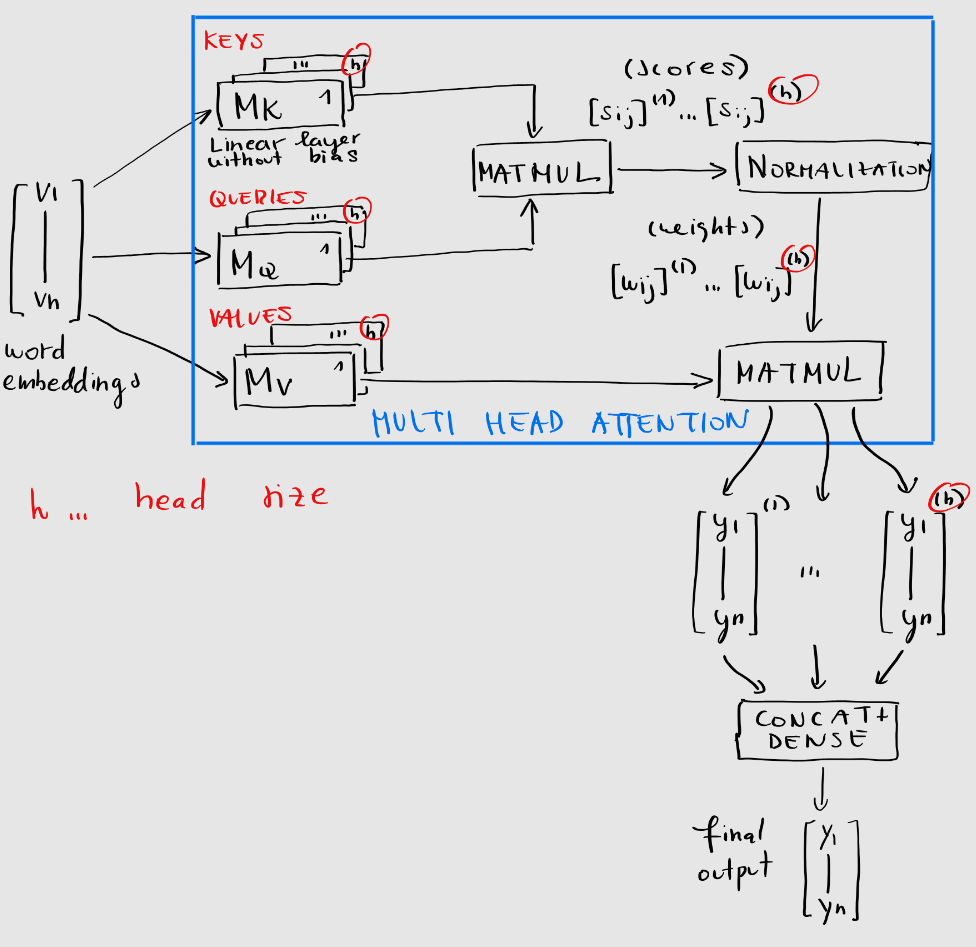

#### What about the masking ?

The attention explained above is applied in the **encoder** block of a transformer, where we allow attention over the whole input sequence, in the **decoder** block we have to introduce **masking**, to make sure that the tokens can attent only to previus tokens (this is further explained in the next section)

### The Matchematical trick in self-attention

The following trick is necessary to effectively compute self attention in the decoder block. We would like to achieve a scheme in which tokens can communicate with each other (*i.e we would like to cupple the tokens*). Tokens should be cuppled in the following way: token at the $i$-th location can only be cuppled with tokens before the $i$-th location. 

***How can the tokens communicate ?***

If we are the $i$-th token and want to communicate with the previus tokens, we can just take the mean of the previous tokens. 




#### Inefficient implementation

In [26]:
# consider the following toy example:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [27]:
# first batch of tokens
# we can see that we have 8 tokens
# where each token if a vector with 2 dimension
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [28]:
xbow = torch.zeros((B,T,C))
for b in range(B): # iterate over batch
    for t in range(T): # iterate over the block_size

        # take 
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [29]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [30]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

#### Efficient implementation ($\#1$)

It turns out that the averaging of previus tokens can be speed up using matrix multiplication.

In [31]:
# lower triangular matrix
a = torch.tril(torch.ones(3,3))
a

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [32]:
# sum over the columns: this is just the number of non zero elements in each row
torch.sum(a, axis=1, keepdim=True)

tensor([[1.],
        [2.],
        [3.]])

In [33]:
# normalize by the number of non zero elements
a = a / torch.sum(a, 1, keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [34]:
# lets take a look at some dummy data matrix
b = torch.randint(0,10,(3,2)).float()
b

tensor([[8., 6.],
        [5., 2.],
        [4., 4.]])

In [35]:
# we can see that after matrix multiplication
# the rows in matrix c are the mean of rows in b
c = a @ b
c

tensor([[8.0000, 6.0000],
        [6.5000, 4.0000],
        [5.6667, 4.0000]])

In [36]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [37]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

# batch matrix multiplication
# individual matrix mult. for each sample in batch
# for one batc: (T, T) @ (T, C) -> (T, C)

# (B, T, T) @ (B, T, C) ----> (B, T, C)
xbow2 = wei @ x
# check if the vectorized and original version returns the same output
torch.allclose(xbow, xbow2)

False

#### Efficient implementation ($\#2$)

The following implementation was used in the original paper [6].

In [38]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T)) # bottom triangular matrix
wei = torch.zeros((T,T))            # matrix of just zeros
wei = wei.masked_fill(tril == 0, float('-inf')) # make wei -inf where tril is zero (upper triangle)
wei = F.softmax(wei, dim=-1)        # softmax along the row (exp. each element in row and devide by the sum of the exp. row)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

False

In [39]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

`wei` is initially zero (we can think of this as the intercation strength, i.e how much of each token in the past do we wan't to average out). This so called affinities are data dependent (meaning that they will get learned).

In [40]:
wei = torch.zeros((T,T))
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

The line bellow tells us that token that have a `-inf` associated with them, cannot be used to predict the next token. This insures that the future cannot communicate with the past.

In [41]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

We get the same matrix after applying the softmax.

In [42]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [43]:
# cupple the tokens
xbow3 = wei @ x
xbow3[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

### Hands on Self-Attention

In this section we implement a single head self attention. 

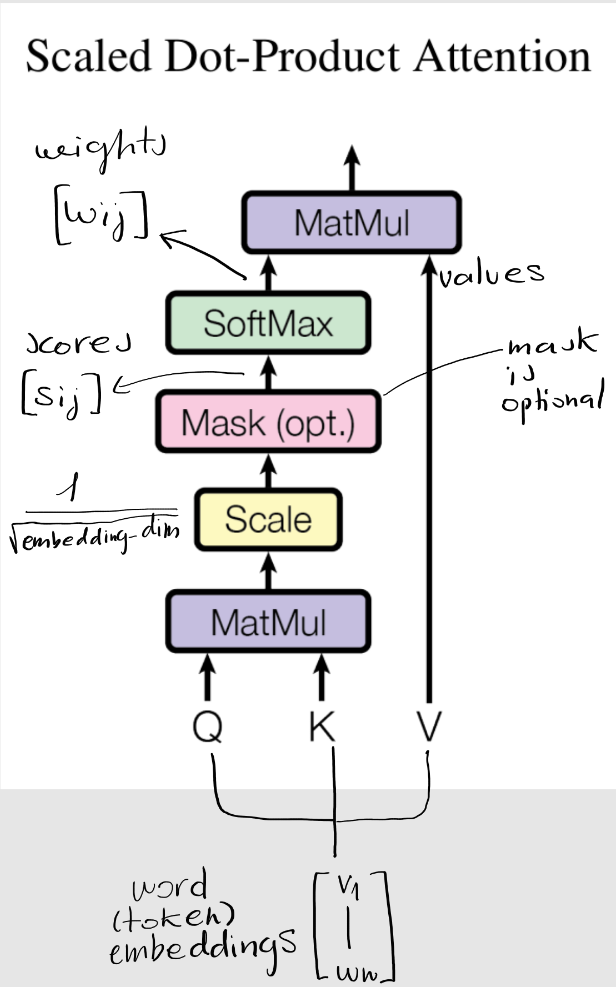

#### Lets create a set of dummy token embeddings



In [44]:
torch.manual_seed(1337)
embedding_dim=16
token_embeddings = torch.randn(block_size, embedding_dim)

# we have 8 embeddings of size embedding_dim
token_embeddings.shape

torch.Size([8, 16])

#### Visualize the dummy embeddings

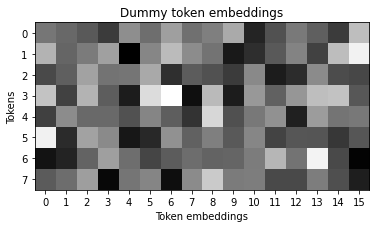

In [45]:
plt.imshow(
    token_embeddings.detach().numpy(),
    cmap="gray"
)

plt.title("Dummy token embeddings")
plt.ylabel("Tokens")
plt.xlabel("Token embeddings")
plt.yticks(list(range(block_size)));
plt.xticks(list(range(embedding_dim)))
plt.plot();

#### Define the *Query*, *Key*, *Value* Layer


Recall from the theory section, that this are the matrices which we can learn during training. Also recall that these layers dont have any bias.

In [46]:
head_size = 16 # hyper-parameter
key   = nn.Linear(embedding_dim, head_size, bias=False) # this will just apply matrix multiplication
query = nn.Linear(embedding_dim, head_size, bias=False) # this will just apply matrix multiplication
value = nn.Linear(embedding_dim, head_size, bias=False) # this will just apply matrix multiplication

#### Pass the `token_embeddings` into the *Query* and *Key* layer

We can think of this stage as follows:

Every token emittes a *query* and a *key*. The *query* vector roughly speeking encodes the following question: "*what am i looking for ?*", the *key* vector encodes "*what do i contain ?*". 

In [47]:
k = key(token_embeddings)   
q = query(token_embeddings) 

k.shape, q.shape

(torch.Size([8, 16]), torch.Size([8, 16]))

#### Perform the MatMul between queries and the keys

Recall that this performs the dot product between *queries* and the *keys* and produces the scores matrix `S`. If a *query* and a *key* are aliggned we get a high score (i.e high interaction).

In [48]:
S = q @ k.transpose(-2, 1)
S.shape

torch.Size([8, 8])

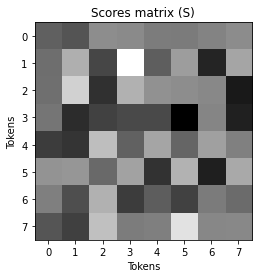

In [49]:
plt.imshow(
    S.detach().numpy(),
    cmap="gray"
);

plt.xticks(list(range(block_size)));
plt.yticks(list(range(block_size)));
plt.title("Scores matrix (S)")
plt.xlabel("Tokens");
plt.ylabel("Tokens");

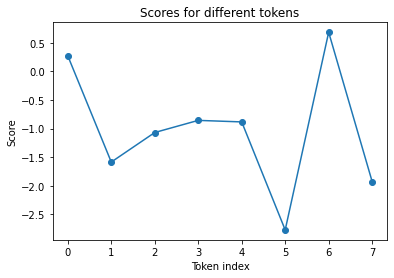

In [50]:
token_idx = 3

plt.plot(S[token_idx, :].detach().numpy(), "o-")
plt.xlabel("Token index")
plt.ylabel("Score")
plt.title("Scores for different tokens");

#### Scale the scores

We scale the scores to control the variance of values.

In [51]:
S = S * embedding_dim**-0.5

#### Apply the mask

We are implementing the self-attention for the decoder part of the transformer, therefore we have to mask out the future tokens


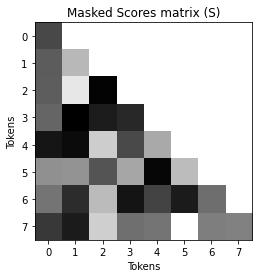

In [55]:
tril = torch.tril(torch.ones(8, 8))
S = S.masked_fill(tril == 0, float('-inf'))

plt.imshow(
    S.detach().numpy(),
    cmap="gray"
)

plt.xticks(list(range(block_size)));
plt.yticks(list(range(block_size)));
plt.title("Masked Scores matrix (S)")
plt.xlabel("Tokens");
plt.ylabel("Tokens");

#### Apply the softmax

This will normalize the scores. 

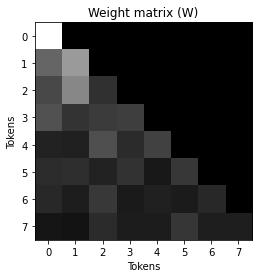

In [56]:
W = F.softmax(S, dim=-1)
plt.imshow(
    W.detach().numpy(),
    cmap="gray"
)

plt.xticks(list(range(block_size)));
plt.yticks(list(range(block_size)));
plt.title("Weight matrix (W)")
plt.xlabel("Tokens");
plt.ylabel("Tokens");

From the plot bellow we can see that the Weight for future tokens is zero.

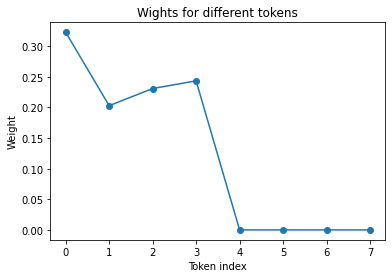

In [59]:
token_idx = 3

plt.plot(W[token_idx, :].detach().numpy(), "o-")
plt.xlabel("Token index")
plt.ylabel("Weight")
plt.title("Wights for different tokens");

#### Pass the `token_embeddings` through the *Value* layer

In [60]:
v = value(token_embeddings)
v.shape

torch.Size([8, 16])

#### Perform the weighted aggregation of the values

The output is a set of tokens with added context.

In [61]:
# weight individual values
out = W @ v
out.shape

torch.Size([8, 16])

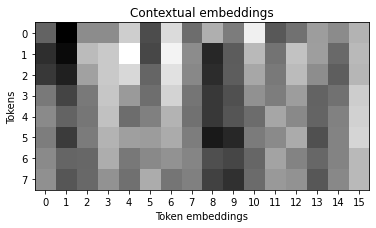

In [62]:
plt.imshow(
    out.detach().numpy(),
    cmap="gray"
)

plt.ylabel("Tokens")
plt.xlabel("Token embeddings")
plt.yticks(list(range(block_size)));
plt.xticks(list(range(embedding_dim)))
plt.title("Contextual embeddings")
plt.plot();

#### Finally lets implement a Self attention Head class


In [63]:
class Head(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()

        # (1) Create key, query, value linear layers
        self.key   = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)

        # (2) Create and register the tril matrix
        torch.tril(torch.ones(block_size, block_size))
        self.register_buffer(
            "tril",
            torch.tril(torch.ones(block_size, block_size))
        ) 

    def forward(self, x):
        batch_size, block_size, channels = x.shape

        # (1) Pass the input through the keys and queries linear layers
        k = self.key(x)
        q = self.query(x)

        # (2) Compute attention scores
        S = q @ k.transpose(-2, -1)

        # (3) Normalize the scores
        S = S * (channels ** -0.5)

        # (4) Apply the mask
        # Makes sure that the future doesn't communicate with the past
        S = S.masked_fill(self.tril[:block_size, :block_size] == 0, float('-inf'))
        
        # (5) Apply the softmax
        W = F.softmax(S, dim=-1)

        # (6) Perform the weighted aggregation of the values
        v = self.value(x)
        out = W @ v

        return out

In [64]:
# Lets test the inference
B, T, C = 4, 8, 32  # [batch_size, time, channels]
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 32])

In [65]:
self_attention_head = Head(embedding_dim=C, head_size=16)
out = self_attention_head(x)
out.shape

torch.Size([4, 8, 16])

### Hands on Multi-head attention

We'll use multiple self attention Heads in parallel. This allows us to have multiple communication channels.

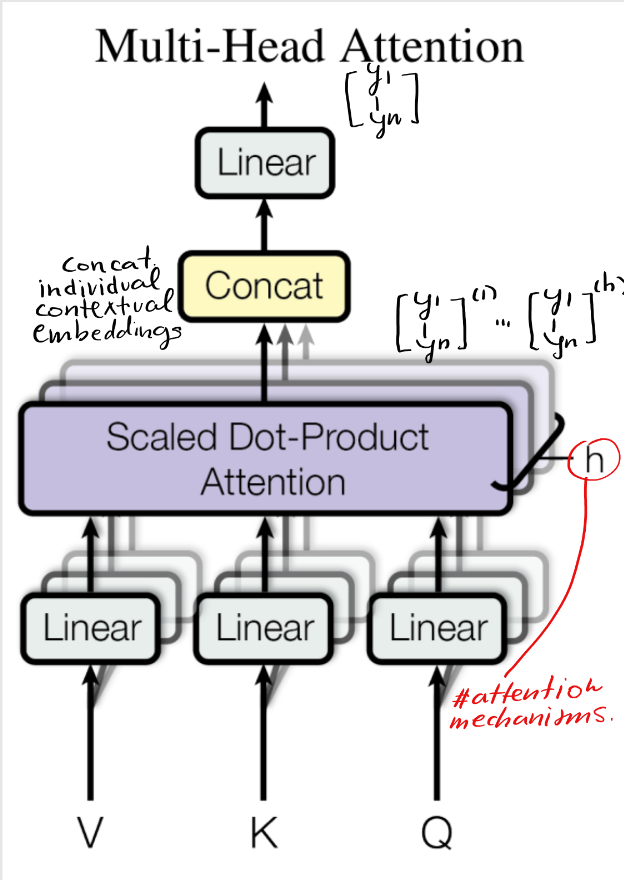

In [66]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, embedding_dim, head_size):
        super().__init__()

        # Create multiple heads
        self.heads = nn.ModuleList(
            [Head(embedding_dim, head_size) for _ in range(num_heads)]
        )

    def forward(self, x):
        # Run all heads in parallel, and concat. over the channel dimension
        out = torch.cat(
            [head(x) for head in self.heads],
            dim=-1
        )

        return out

In [67]:
# Lets test the inference
B, T, C = 4, 8, 32  # [batch_size, time, channels]
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 32])

In [68]:
N_HEADS = 3

multi_head_attention = MultiHeadAttention(
    num_heads=N_HEADS,
    embedding_dim=C,
    head_size=32
)

In [69]:
out = multi_head_attention(x)
out.shape

torch.Size([4, 8, 96])

In [70]:
out.shape[-1] // C == N_HEADS

True

### Feed forward Layers

By adding the feed forward layers we add aditional capacity to the network. The linear layer is applied on the per token level.


We should add the feed forward layer after the Multi Head attention layer.

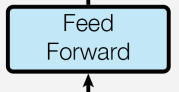

In [80]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, embedding_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [93]:
# Lets test the inference
B, T, C = 4, 8, 32  # [batch_size, time, channels]
x = torch.randn(B, T, C)
x.shape

N_HEADS = 4
multi_head_attention = MultiHeadAttention(
    num_heads=N_HEADS,
    embedding_dim=C,
    head_size=C // N_HEADS # we set the head size s.t the number of channels stays constant
)

In [94]:
out = multi_head_attention(x)
out.shape

torch.Size([4, 8, 32])

In [95]:
feed_forward = FeedForward(embedding_dim=C)
out = feed_forward(out)
out.shape

torch.Size([4, 8, 32])

At this point we wan't to join the Multi Head Attention module and Feed Foward module into a single block. Lets implement a class called `Block` which does this:

In [97]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        # Compute the head size such that after appliyng `num_heads` of heads
        # the number of channels stays constant.
        head_size = embedding_dim // num_heads

        self.self_attention = MultiHeadAttention(num_heads, embedding_dim, head_size)
        self.feed_forward = FeedForward(embedding_dim)

    def forward(self, x):
        # (1) Apply the self attention
        out = self.self_attention(x)

        # (2) Apply the feed forward layer
        out = self.feed_forward(out)

        return out

Now we can simply stack the individual blocks

In [100]:
embedding_dim = 32
num_heads = 4

blocks = nn.Sequential(
    Block(embedding_dim, num_heads),
    Block(embedding_dim, num_heads),
    Block(embedding_dim, num_heads),
)

In [102]:
# Lets test the inference
x = torch.randn(4, 8, embedding_dim)
x.shape

torch.Size([4, 8, 32])

In [104]:
out = blocks(x)
out.shape

torch.Size([4, 8, 32])

### Residual (Skip) Connection

To make sure that the networks remain optimizable, we introduce the skip connections (*prevents the vanishing gradient problem*). 

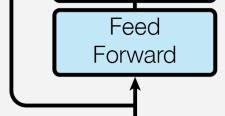

Lets add residual connections to the `Block` implemented above.

In [122]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        # Compute the head size such that after appliyng `num_heads` of heads
        # the number of channels stays constant.
        head_size = embedding_dim // num_heads

        self.self_attention = MultiHeadAttention(num_heads, embedding_dim, head_size)
        self.feed_forward = FeedForward(embedding_dim)

    def forward(self, x):
        # (1) Apply the self attention with residual block
        out = x + self.self_attention(x)

        # (2) Apply the feed forward layer with residual block
        out = out + self.feed_forward(out)

        return out

Finally we have to add the projection (projection back into the residual pathway) layer on top of the output of the self attention and the output of the linear layer

In [123]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, embedding_dim, head_size):
        super().__init__()

        # Create multiple heads
        self.heads = nn.ModuleList(
            [Head(embedding_dim, head_size) for _ in range(num_heads)]
        )

        # Introduce a projection layer
        self.projection = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        # Run all heads in parallel, and concat. over the channel dimension
        out = torch.cat(
            [head(x) for head in self.heads],
            dim=-1
        )

        # Apply the projection
        out = self.projection(out)

        return out

In [124]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, embedding_dim):
        super().__init__()

        # Add a projection layer to the net
        # Also note that we increased the output size
        # of the first layer (this is a sugestion form the paper)
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
        )

    def forward(self, x):
        return self.net(x)

In [125]:
embedding_dim = 32
num_heads = 4

blocks = nn.Sequential(
    Block(embedding_dim, num_heads),
    Block(embedding_dim, num_heads),
    Block(embedding_dim, num_heads),
)

In [126]:
# Lets test the inference
x = torch.randn(4, 8, embedding_dim)
x.shape

torch.Size([4, 8, 32])

In [127]:
out = blocks(x)
out.shape

torch.Size([4, 8, 32])

### Layer Normalization

Layer normalization (LN) is a normalazitation technique used to improve training stability and reduce dependence on the initial scale of the weights. LN normalizes the activations across all units withing a single layer. 


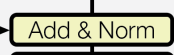

In [128]:
x = torch.randn(batch_size, embedding_dim)
x.shape

torch.Size([4, 32])

In [130]:
# normalize across the embedding dimension
layer_norm = nn.LayerNorm(
    normalized_shape=embedding_dim
)

In [131]:
x_out = layer_norm(x)

We can see that the output of the layer norm has normalized rows, i.e we applied normalization accross the embedding dimension.

In [135]:
x[0, :].mean().item(), x[0, :].std().item()

(0.03651388734579086, 0.8202254176139832)

In [134]:
x_out[0, :].mean().item(), x_out[0, :].std().item()

(0.0, 1.0159932374954224)

We can add the LA to the `Block` class

In [136]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        # Compute the head size such that after appliyng `num_heads` of heads
        # the number of channels stays constant.
        head_size = embedding_dim // num_heads

        self.self_attention = MultiHeadAttention(num_heads, embedding_dim, head_size)
        self.feed_forward = FeedForward(embedding_dim)

        # Add layer normaliation
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # (1) Apply the self attention with residual block
        out = x + self.self_attention(
            self.layer_norm1(x)
        )

        # (2) Apply the feed forward layer with residual block
        out = out + self.feed_forward(
            self.layer_norm1(out)
        )

        return out

### Implement a Language Model class


In this section we'll add all individual components to a single LanguageModel class. You can also refer directly to the authors git repo (https://github.com/karpathy/nanoGPT)

#### Final Model

In [137]:
class LanguageModel(nn.Module):
    # TODO
    pass

#### Training Loop